# Exercise 4 - Transmon qubit

## Historical background

In quantum computing, a qubit is the basic unit of quantum information. It is essentially a two-level quantum mechanical system, can be implemented in many physical systems, including natural systems such as electron spins (spin qubit), atomic levels in ions (trapped ion qubits) or artificial systems such as states in a superconducting circuit (superconducting qubit).

The original superconducting qubit was the Cooper Pair Box debuted in 1999[1], in which a well-defined number of Cooper pairs (bound electrons in a superconductor) occupy an island of superconductor weakly coupled to a lead by a Josephson junction. In Cooper pair box qubit, the energy difference between the $|0\rangle$ state (no Cooper Pairs) and $|1\rangle$ state (a single Cooper Pair)is strongly dependent on any stray or applied electrostatic charges in or around the system. This sensitivity to charge noise leads to qubit dephasing. The qubit dephasing time ($T_2$) for Cooper pair box qubit is typically limited to ~ 1$\mu s$.

The key discovery behind the transmon qubit, first proposed in 2007[2], is that this energy dependence on voltage (known as dispersion) is periodic. By introducing a shunting capacitor, the ratio between the Josephson energy and charging energy $E_J/E_c$ become very large ~ 50, leading to a flat charge dispersion. While Cooper pair box is very sensitive to the charge noise (i.e. uncertainty in x axis position in Fig. 1a), it is largely suppressed in transmon qubit (Fig. 1d). The qubit dephasing time ($T_2$) for transmon qubit is improved significantly. In IBM Quantum systems, $T_2$ is typically ~ 100 $\mu s$. See [`ibmq_santiago`](https://quantum-computing.ibm.com/services?skip=0&systems=all&system=ibmq_santiago) for example.

<figure>
    <img src="resources/transmon-charge-dispersion.png" alt="Transmon charge dispersion" style="width:50%">
    <center><figcaption><b>Fig. 1</b> Charge dispersion of qubit for different ratios $E_J/E_c$. (from Ref [2])</figcaption></center>
</figure>

In this exercise, you will investigate the characteristic energies of the transmon qubit by performing spectroscopy with a real IBM Quantum system. the ratio between the Josephson energy and charging energy $E_J/E_c$ is the key to solving the charge noise problem of its predecessor, the Cooper Pair Box qubit.

### References

1. Nakamura, Yasunobu, Yu A. Pashkin, and Jaw Shen Tsai. "Coherent control of macroscopic quantum states in a single-Cooper-pair box." Nature 398.6730 (1999): 786-788.
2. Koch, Jens, et al. "Charge-insensitive qubit design derived from the Cooper pair box." Physical Review A 76.4 (2007): 042319.
3. Krantz, Philip, et al. "A quantum engineer's guide to superconducting qubits." Applied Physics Reviews 6.2 (2019): 021318.

## Energy levels and characteristic energies of the transmon qubit

The Hamiltonian of quantum harmonic oscillator (QHO) can be obtained by quantizing Hamiltonian of a linear LC circuit. Its energy levels are equally spaced (Fig. 2c). By introducing a non-linear circuit element, the Josephson junction, the energy levels of the transmon qubit is modified (Fig. 2d). The **energy levels are no longer equally spaced**. **Higher energy level spacing is smaller than those of lower energies**. The anharmonicity $\delta$ is defined as the energy difference between $|1\rangle \rightarrow |2\rangle$ and $|0\rangle \rightarrow |1\rangle$ transition: $\delta = \hbar \omega_{12} - \hbar \omega_{01}$ or simply $\omega_{12} - \omega_{01}$ (we'll set $\hbar \equiv 1$ for the remainder of this discussion). By tunning the microwave frequency to $\omega_{01}$, we can effectively address the multi-level transmon as a two-level system, i.e. a qubit.

<figure>
    <img src="resources/transmon-energy-levels.png" alt="Transmon energy levels" style="width:50%">
    <center><figcaption><b>Fig. 2</b> Energy potential for a quantum harmonic oscillator and a trasmon qubit. (from Ref [3])</figcaption></center>
</figure>

In superconductors, electrons form Cooper pairs with the effective charge of $2e$, where $e$ is the charge of a single electron. The **charging energy $E_c$** is the energy cost of adding a single Cooper pair to the qubit and is related to the capacitance of the superconducting circuit. The **Josephson energy $E_J$** is the energy of the Cooper pairs tunneling through the Josephson junction. In transmon qubits, the inductive energy is wholly provided by the Josephson junction, but this is not true of other styles of superconducting qubit (for information on the design and analysis of superconducting qubits, [Qiskit Metal](https://qiskit.org/metal/) has recently been released!).

By deriving the Duffing oscillator Hamiltonian from the Cooper Pair Box Hamiltonian, these energies can be related to the relevant transmon frequencies as

$$
f_{01} = \sqrt{8 E_c E_J} - E_c \qquad E_c = -\delta = f_{01} - f_{12},
$$

We will use $f$ to **replace $\omega$ as the symbol for frequency** for the rest of the notebook, because it is more commonly used for microwave. The **anharmonicity $\delta$** is wholly provided by the charging energy $E_c$. Physically, this is incorporated as a large *shunting* (parallel) capacitor to the junction. This addition allows well-separated transmon levels while suppressing susceptibility to the charge noise. 

## Qiskit Pulse overview

So far, you have been playing with qubits in the abstract quantum circuit level. Physically the quantum gates in circuits are implemented as microwave pulses. Qiskit Pulse provides you pulse level access to manipulate the microwave pulses sending to IBM Quantum system.

As a brief overview, Qiskit Pulse schedules (experiments) consist of Instructions (e.g., Play) acting on Channels (e.g., the drive channel). Here is a summary table of available Instructions and Channels:

![image](resources/pulse-instr.png)

For more details, this table summarizes the interaction of the channels with the actual quantum hardware:

![image](resources/pulse-user-device-layers.png)

You can learn more about Qiskit Pulse on [Qiskit documentation](https://qiskit.org/documentation/apidoc/pulse.html). However, we find it is more instructive to begin with guided programming in Pulse. Below you will learn how to create pulses, schedules, and run experiments on a real quantum system. 

## Let's get started!

<div class="alert alert-block alert-success">

**Goal**
    
Find $|1\rangle \rightarrow |2\rangle$ transition frequency $f_{12}$.
    
**Plan**
    
1. **(Tutorial) Find $|0\rangle \rightarrow |1\rangle$ transition frequency $f_{01}$** using spectroscopy (sweeping frequency).
1. **(Tutorial) Calibrate X-180 pulse amplitude** using Rabi oscillation (sweeping amplitude).
1. **(Problem) Find $|1\rangle \rightarrow |2\rangle$ transition frequency $f_{12}$** using the calibrated X-180 pulse and spectroscopy (sweeping frequency).
    
</div>

<div class="alert alert-block alert-danger">

**You will only need to <a href="#problem">modify one cell</a> within this notebook.** You may also need to <a href="#fit-f12">modify the fitting parameters</a> to get a good fit. But other than that, in rest of the cells, nothing needs to be modified. However, you will need to execute the cells by pressing `shift+Enter` in each code block. 

</div>

In order to keep things tidy and focus on the important aspects of Qiskit Pulse, the following cells make use of methods from the `helper` module. For the gory details, please refer to the [Investigating Quantum Hardware Using Microwave Pulses
](https://qiskit.org/textbook/ch-quantum-hardware/index-pulses.html) chapter of the Qiskit Textbook and Lectures 16-21, Labs 6-7 of the [Qiskit Global Summer School](https://qiskit.org/learn/intro-qc-qh/).

In [401]:
# Import helper module from local folder
import sys
import os
sys.path.append(os.getcwd()) 
from resources import helper

# Numerical and plotting tools
import numpy as np
import matplotlib.pyplot as plt

# Import SI unit conversion factors
from resources.helper import GHz, MHz, kHz, us, ns

<div class="alert alert-block alert-danger">
 
**Special provider**
    
We have reserved a brand new `ibmq_jakarta` quantum system for the challenge. Participants will have exclusive access to the system during the challenge period (May 20 - 26, 2021) through a special [provider](https://quantum-computing.ibm.com/composer/docs/iqx/manage/provider/#providers). You need to **complete at least one of the five exercises** in the challenge to get assigned to a special provider for the challenge. When you do, you will receive an email with header `You have been added to a new project in IBM Quantum` in the email address associated with your IBM Quantum account. If everything work properly, you should be able to see the information of the special provider in [your account details page](https://quantum-computing.ibm.com/account).
    
Your IBM Quantum account needs to be associated with an IBMid. Otherwise, you will encounter this error `Login with some authorized required.`. Please [register a new IBMid](https://auth.quantum-computing.ibm.com/auth/idaas) using the SAME email address associated with your IBM Quantum account and login to [IBM Quantum](https://quantum-computing.ibm.com) again.
    
**Note: It may take up to 12 hours to get assigned to the provider upon completion of other exercises.** If you face any issues, please reach out to us in [#iqc2021](https://qiskit.slack.com/archives/C021UTFN9GE) channel. Join the Qiskit Slack workspace [here](https://ibm.co/joinqiskitslack) if you haven't already.
    
</div>

Run the cell below to check if you have been assigned to a special provider. If you are added to a special provider, you should be able to see in the output a provider looks like this `<AccountProvider for IBMQ(hub='iqc2021-n', group='challenge-m', project='ex4')>` where `n` is a number goes from `1` to `10` and `m` is a number goes from `1` to `1000`. You will need this information to get access to `ibmq_jakarta` quantum system reserved for the challenge. 

In [402]:
# Importing standard Qiskit libraries
from qiskit import IBMQ
from qiskit.tools.jupyter import *

# Loading your IBM Quantum account
IBMQ.load_account()
IBMQ.providers() # see a list of providers you have access to

ibmqfactory.load_account:WARNING:2021-05-25 19:14:44,740: Credentials are already in use. The existing account in the session will be replaced.


[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>,
 <AccountProvider for IBMQ(hub='iqc2021-2', group='challenge-79', project='ex4')>]

In [403]:
# Get the special provider assigned to you using information from the output above
hub_name = 'iqc2021-2' # e.g. 'iqc2021-1'
group_name = 'challenge-79' # e.g. 'challenge-1'
project_name = 'ex4' # Your project name should be 'ex4'
provider = IBMQ.get_provider(hub=hub_name, group=group_name, project=project_name)

# Get `ibmq_jakarta` backend from the provider
backend_name = 'ibmq_jakarta'
backend = provider.get_backend(backend_name)
backend # See details of the `ibmq_jakarta` quantum system

<IBMQBackend('ibmq_jakarta') from IBMQ(hub='iqc2021-2', group='challenge-79', project='ex4')>

### Instantiate channels and retrieve measurement schedule

We will use the same measurement schedule throughout, whereas the drive schedules will vary. For any backend, we can ask for its default measurement pulse instead of calibrating it separately.

In [404]:
from qiskit import pulse
from qiskit.pulse import Play, Schedule, DriveChannel

# Please use qubit 0 throughout the notebook
qubit = 0

Next, save the backend configuration and the sampling time $dt$. We will exclude the `AcquireChannel`s when plotting for clarity.

In [405]:
backend_config = backend.configuration()
exc_chans = helper.get_exc_chans(globals())
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns") 

Sampling time: 0.2222222222222222 ns


The `instruction_schedule_map` provides the parameters of the default calibrated pulses used by the backend. In particular, we see that this "native gate set" consists of a subset of operations you can perform on a [`QuantumCircuit`](https://qiskit.org/documentation/apidoc/circuit.html#gates-and-instructions), and is the gate set that the `QuantumCircuit` is transpiled to by Qiskit. 

In [406]:
backend_defaults = backend.defaults()
center_frequency = backend_defaults.qubit_freq_est
inst_sched_map = backend_defaults.instruction_schedule_map 
inst_sched_map.instructions

['cx', 'id', 'measure', 'rz', 'sx', 'u1', 'u2', 'u3', 'x']

The instructions consist of the native gate set of the backend: single-qubit gates square-root of $X$, `sx`, and parameterized rotation about the $Z$-axis, `rz(θ)`, and the two-qubit controlled-NOT, `cx`. There are several other gates listed here, in particular the soon-to-be deprecated ["U-gates"](https://qiskit.org/textbook/ch-states/single-qubit-gates.html#generalU3) based on Euler angles, summarized below for completeness

Basis Gate | Operation
 --- | ---
 `u1(λ)` | `rz(λ)`
 `u2(φ,λ)` | `rz(φ+π/2) sx rz(λ-π/2)`
 `u3(θ,φ,λ)` | `rz(φ+π) sx rz(θ+π) sx rz(λ)`
 `id` | identity
 `x` | $X$ for echoes in dynamical decoupling
 `measure` | measurement

One thing to note is that each `sx` consists of one physical pulse and the `rz`s are implemented in software by [frame changes](https://arxiv.org/abs/1612.00858). From the `instruction_schedule_map` we can retrieve the default measurement pulse instead of building it from scratch. This also serves as a useful starting point from retrieving calibrated pulses and manipulating them further.

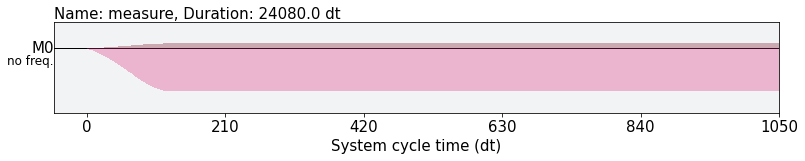

In [407]:
# Retrieve calibrated measurement pulse from backend
meas = inst_sched_map.get('measure', qubits=[qubit])
meas.exclude(channels=exc_chans).draw(time_range=[0,1000])

<div class="alert alert-block alert-success">

## Step 1 (Tutorial): Find $|0\rangle \rightarrow |1\rangle$ transition
    
You don't need to modify any code in this section. Just go through all the cells and make sure you understand the steps. Pay close attention to how `spec01_scheds` is built. You will need to build similar pulse schedules in <a href="#problem">the final problem</a>. You can learn more about how to build pulse schedule in [this tutorial](https://qiskit.org/documentation/tutorials/circuits_advanced/06_building_pulse_schedules.html).
    
</div>

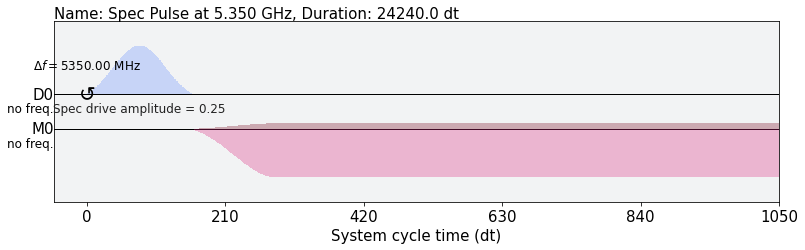

In [408]:
from qiskit.pulse import DriveChannel, Gaussian

# The same spec pulse for both 01 and 12 spec
drive_amp = 0.25
drive_duration = inst_sched_map.get('x', qubits=[qubit]).duration

# Calibrated backend pulse use advanced DRAG pulse to reduce leakage to the |2> state.
# Here we will use simple Gaussian pulse

drive_sigma = drive_duration // 4 # DRAG pulses typically 4*sigma long. 
spec_pulse = Gaussian(duration=drive_duration, amp=drive_amp, 
                        sigma=drive_sigma, name=f"Spec drive amplitude = {drive_amp}")

# Construct an np array of the frequencies for our experiment
spec_freqs_GHz = helper.get_spec01_freqs(center_frequency, qubit)

# Create the base schedule
# Start with drive pulse acting on the drive channel
spec01_scheds = []
for freq in spec_freqs_GHz: # Recorre el arreglo
    with pulse.build(name="Spec Pulse at %.3f GHz" % freq) as spec01_sched:
        with pulse.align_sequential():
            # Pay close attention to this part to solve the problem at the end
            pulse.set_frequency(freq*GHz, DriveChannel(qubit))
            pulse.play(spec_pulse, DriveChannel(qubit))
            pulse.call(meas)
            
    spec01_scheds.append(spec01_sched)

# Draw spec01 schedule
spec01_scheds[-1].exclude(channels=exc_chans).draw(time_range=[0,1000])

In [409]:
spec01_scheds[-1]

Schedule((0, SetFrequency(5350000000.000001, DriveChannel(0))), (0, Play(Gaussian(duration=160, amp=(0.25+0j), sigma=40, name='Spec drive amplitude = 0.25'), DriveChannel(0), name='Spec drive amplitude = 0.25')), (160, Call(Schedule((0, Acquire(22400, AcquireChannel(0), MemorySlot(0))), (0, Acquire(22400, AcquireChannel(1), MemorySlot(1))), (0, Acquire(22400, AcquireChannel(2), MemorySlot(2))), (0, Acquire(22400, AcquireChannel(3), MemorySlot(3))), (0, Acquire(22400, AcquireChannel(4), MemorySlot(4))), (0, Acquire(22400, AcquireChannel(5), MemorySlot(5))), (0, Acquire(22400, AcquireChannel(6), MemorySlot(6))), (0, Play(GaussianSquare(duration=22400, amp=(-0.19422830012052264+0.022262466895925738j), sigma=64, width=22144, name='M_m0'), MeasureChannel(0), name='M_m0')), (22400, Delay(1680, MeasureChannel(0))), name="measure"), name='call_measure')), name="Spec Pulse at 5.350 GHz")

In [410]:
from qiskit.tools.monitor import job_monitor

# Run the job on a real backend
spec01_job = backend.run(spec01_scheds, job_name="Spec 01", **helper.job_params) 

print(spec01_job.job_id())
job_monitor(spec01_job)

# If the queuing time is too long, you can save the job id 
# And retrieve the job after it's done
# Replace 'JOB_ID' with the the your job id and uncomment to line below
#spec01_job = backend.retrieve_job('JOB_ID')

/opt/conda/lib/python3.8/site-packages/qiskit/compiler/assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


60ad4cae8d1c8084aa9620cf
Job Status: job has successfully run


### Fit the Spectroscopy Data

We will fit the spectroscopy signal to a *Lorentzian* function of the form

$$ \frac{AB}{\pi[(f-f_{01})^2 + B^2]} + C $$

to find the qubit frequency $f_{01}$ with these fitting parameters:


Parameter | Corresponds to
 --- | ---
 $A$ | amplitude
 $f_{01}$ | 01 frequency guess (GHz)
 $B$ | scale
 $C$ | offset

 
 We will use the `SpecFitter` from the `helper` module that is based on the fitters from `qiskit.ignis.characterization.fitters` library.
 
<div class="alert alert-block alert-danger">

**Note:** You may need to modify the fitting parameters below to get a good fit.

</div>

Spec01 frequency is 5.237097 GHz


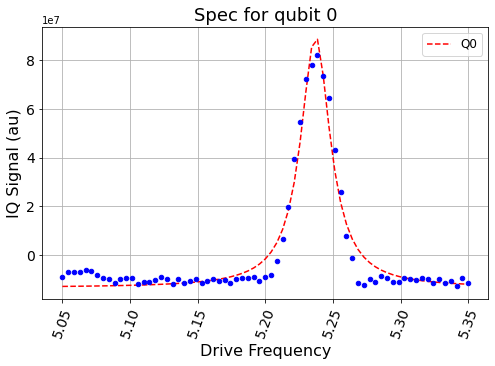

In [411]:
from resources.helper import SpecFitter

amp_guess = 5e6
f01_guess = 5
B = 1
C = 0
fit_guess = [amp_guess, f01_guess, B, C]

fit = SpecFitter(spec01_job.result(), spec_freqs_GHz, qubits=[qubit], fit_p0=fit_guess)
fit.plot(0, series='z')
f01 = fit.spec_freq(0, series='z')
print("Spec01 frequency is %.6f GHz" % f01)

Let's compare your result with the calibrated qubit frequency from the backend! If things are working properly, your result should be very close to the calibrated value ($\pm$1 MHz).

In [412]:
# Retrieve qubit frequency from backend properties
f01_calibrated = backend.properties().frequency(qubit) / GHz 
f01_error = abs(f01-f01_calibrated) * 1000 # error in MHz
print("Qubit frequency error is %.6f MHz" % f01_error) 

Qubit frequency error is 0.706595 MHz


🎉 Congratulations! You have successfully ran your first pulse experiment on a real quantum system and analyzed the data. This was not possible without access to an advanced research lab before [less than two years ago](https://www.ibm.com/blogs/research/2019/12/qiskit-openpulse/), when we released Qiskit Pulse and provided pulse access in our open quantum system `ibmq_armonk`. Now you can do experimental quantum physics on your laptop in the comfort of your home. This is incredible!

In [413]:
f01

5.237096795381991

In [414]:
f01_calibrated

5.2363902007070555

<div class="alert alert-block alert-success">

## Step 2 (Tutorial): Calibrate X-180 pulse amplitude using Rabi oscillation

You don't need to modify any code in this section. Just go through all the cells and make sure you understand the steps. 
</div>

### Build Rabi schedule from measured frequency

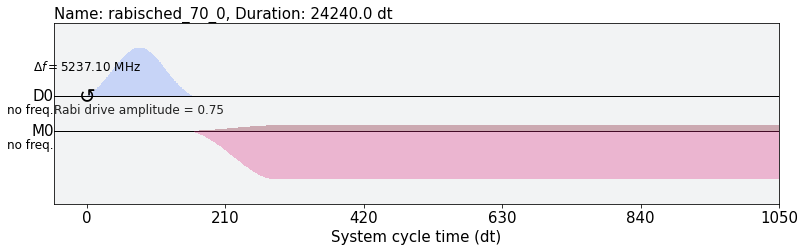

In [415]:
max_rabi_amp = 0.75
rabi_amps = helper.get_rabi_amps(max_rabi_amp)

rabi_scheds = []
for ridx, amp in enumerate(rabi_amps):
    with pulse.build(name="rabisched_%d_0" % ridx) as sched: # '0' corresponds to Rabi
        with pulse.align_sequential():
            pulse.set_frequency(f01*GHz, DriveChannel(qubit))
            rabi_pulse = Gaussian(duration=drive_duration, amp=amp, \
                              sigma=drive_sigma, name=f"Rabi drive amplitude = {amp}")
            pulse.play(rabi_pulse, DriveChannel(qubit))
            pulse.call(meas)
    rabi_scheds.append(sched)

# Draw rabi schedule
rabi_scheds[-1].exclude(channels=exc_chans).draw(time_range=[0,1000])

In [416]:
# Run the job on a real device
rabi_job = backend.run(rabi_scheds, job_name="Rabi", **helper.job_params)

print(rabi_job.job_id())
job_monitor(rabi_job)

# If the queuing time is too long, you can save the job id 
# And retrieve the job after it's done
# Replace 'JOB_ID' with the the your job id and uncomment to line below
#rabi_job = backend.retrieve_job('JOB_ID')

/opt/conda/lib/python3.8/site-packages/qiskit/compiler/assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


60ad4dd993ec54fb9c23893f
Job Status: job has successfully run


### Fit the Rabi Data

We will fit the Rabi signal to a sinusoidal function of the form

$$ a \cos(2\pi f x + \phi) + c $$

to find the Rabi period $T = 2\pi/f$ with these fitting parameters:


Parameter | Corresponds to
 --- | ---
 $a$ | amplitude
 $f$ | Rabi drive frequency
 $\phi$ | phase offset
 $c$ | offset


We will use the `RabiFitter` from the `qiskit.ignis.characterization.calibration.fitters` library.

<div class="alert alert-block alert-danger">

**Note:** You may need to modify the fitting parameters below to get a good fit.

</div>

Pi amplitude is 0.205


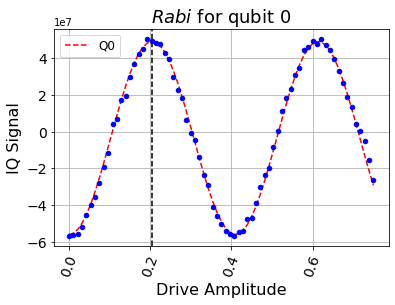

In [417]:
from qiskit.ignis.characterization.calibrations.fitters import RabiFitter

amp_guess = 5e7
fRabi_guess = 2
phi_guess = 0.5
c_guess = 0
fit_guess = [amp_guess, fRabi_guess, phi_guess, c_guess]

fit = RabiFitter(rabi_job.result(), rabi_amps, qubits=[qubit], fit_p0=fit_guess)
fit.plot(qind=0, series='0')
x180_amp = fit.pi_amplitude()
print("Pi amplitude is %.3f" % x180_amp)

<div id='problem'></div>
<div class="alert alert-block alert-success">

## Step 3 (Problem): Find $|1\rangle \rightarrow |2\rangle$ transition frequency
    
In order to observe the transition between the $|1\rangle$ and $|2\rangle$ states of the transmon, you need to: 

1. Apply an $X_\pi$ pulse to transition the qubit from $|0\rangle$ to $|1\rangle$.
1. Apply a second pulse with varying frequency to find the $|1\rangle \rightarrow |2\rangle$ transition.

</div>
<div class="alert alert-block alert-danger">
The cell below is the only one you need to modify in the entire notebook. 
</div>

In [459]:
# Define pi pulse
x_pulse = Gaussian(duration=drive_duration,
                     amp=x180_amp, 
                     sigma=drive_sigma,
                     name='x_pulse')

def build_spec12_pulse_schedule(freq, anharm_guess_GHz):    
    with pulse.build(name="Spec Pulse at %.3f GHz" % (freq+anharm_guess_GHz)) as spec12_schedule:
        with pulse.align_sequential():        
            
            # WRITE YOUR CODE BETWEEN THESE LINES - START
            
            # |0> ---> |1>
            pulse.set_frequency(f01*GHz, DriveChannel(qubit))
            pulse.play(x_pulse, DriveChannel(qubit))
            
            
            # |1> ---> |2>
            drive_amp = 0.25
            drive_duration = inst_sched_map.get('x', qubits=[qubit]).duration
            drive_sigma = drive_duration // 4 # DRAG pulses typically 4*sigma long. 
            spec_pulse = Gaussian(duration=drive_duration, amp=drive_amp, 
                                    sigma=drive_sigma, name=f"Spec drive amplitude = {drive_amp}")
            # Pay close attention to this part to solve the problem at the end
            pulse.set_frequency((freq+anharm_guess_GHz)*GHz, DriveChannel(qubit))
            pulse.play(spec_pulse, DriveChannel(qubit))
            
            # Measurement
            pulse.call(meas)
            # WRITE YOUR CODE BETWEEN THESE LINES - END
    return spec12_schedule


The anharmonicity of our transmon qubits is typically around $-300$ MHz, so we will sweep around that value. 

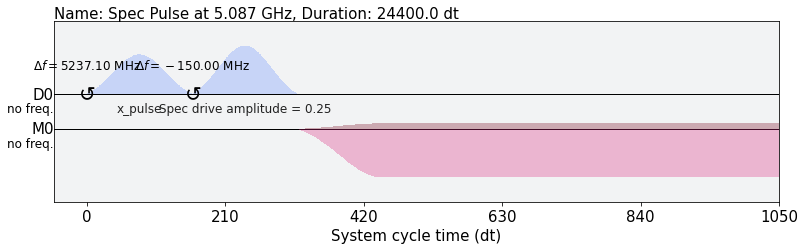

In [460]:
anharmonicity_guess_GHz = -0.3 # your anharmonicity guess
freqs_GHz = helper.get_spec12_freqs(f01, qubit)

# Now vary the sideband frequency for each spec pulse
spec12_scheds = []
for freq in freqs_GHz:
    spec12_scheds.append(build_spec12_pulse_schedule(freq, anharmonicity_guess_GHz))

# Draw spec12 schedule   
spec12_scheds[-1].exclude(channels=exc_chans).draw(time_range=[0,1000])

In [462]:
f01

5.237096795381991

In [463]:
# Run the job on a real device
spec12_job = backend.run(spec12_scheds, job_name="Spec 12", **helper.job_params)

print(spec12_job.job_id())
job_monitor(spec12_job)

# If the queuing time is too long, you can save the job id 
# And retrieve the job after it's done
# Replace 'JOB_ID' with the the your job id and uncomment to line below
#spec12_job = backend.retrieve_job('JOB_ID')

/opt/conda/lib/python3.8/site-packages/qiskit/compiler/assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


60ad52578d1c80477996213c
Job Status: job has successfully run


### Fit the Spectroscopy Data

<div id='fit-f12'></div>

We will again fit the spectroscopy signal to a Lorentzian function of the form

$$ \frac{AB}{\pi[(f-f_{12})^2 + B^2]} + C $$

to find the frequency of the $|1\rangle \to |2\rangle$ transition $f_{12}$ with these fitting parameters:

Parameter | Corresponds to
 --- | ---
 $A$ | amplitude
 $f_{12}$ | 12 frequency guess (GHz)
 $B$ | scale
 $C$ | offset
 
 
<div class="alert alert-block alert-danger">

**Note:** You may need to modify the fitting parameters below to get a good fit.

</div>

Spec12 frequency is 4.898061 GHz


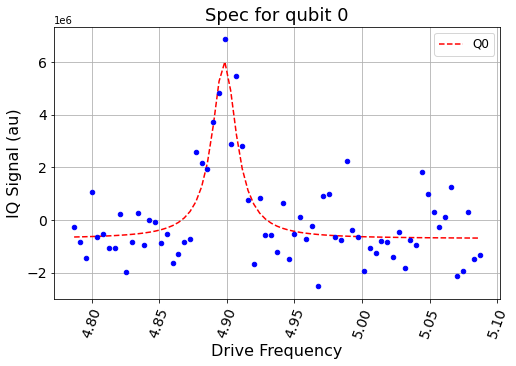

In [464]:
amp_guess = 2e7
f12_guess = f01 - 0.3
B = .1
C = 0
fit_guess = [amp_guess, f12_guess, B, C]

fit = SpecFitter(spec12_job.result(), freqs_GHz+anharmonicity_guess_GHz, qubits=[qubit], fit_p0=fit_guess)
fit.plot(0, series='z')
f12 = fit.spec_freq(0, series='z')
print("Spec12 frequency is %.6f GHz" % f12)

In [465]:
# Check your answer using following code
from qc_grader import grade_ex4
grade_ex4(f12,qubit,backend_name)

Grading your answer for ex4. Please wait...

Congratulations 🎉! Your answer is correct.
Feel free to submit your answer.



In [466]:
# Submit your answer. You can re-submit at any time.
from qc_grader import submit_ex4
submit_ex4(f12,qubit,backend_name)

Submitting your answer for ex4. Please wait...
Success 🎉! Your answer has been submitted.


## Calculating $E_J/E_c$

Modifying the equations in the introduction section, we can calculate $E_c$ and $E_J$ using $f_{01}$ and $f_{12}$ obtained from the pulse experiments:

$$
E_c = -\delta = f_{01} - f_{12} \qquad E_J = \frac{(2f_{01}-f_{12})^2}{8(f_{01}-f_{12})}
$$

In [467]:
Ec = f01 - f12
Ej = (2*f01-f12)**2/(8*(f01-f12))
print(f"Ej/Ec: {Ej/Ec:.2f}") # This value is typically ~ 30 

Ej/Ec: 33.81


## Additional information

**Created by:** Nick Brønn, Junye Huang

**Version:** 1.0.0